In [1]:
###Lineares Regressionsmodell zur Vorhersage von Marktwerten von FIFA20 Feldspielern.
#Dataset: https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset

In [2]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data subdirectory
dir = './data/'

#load data into df and remove players with zero market value
#exclude free transfer players 
df = pd.read_csv(dir + "players_20.csv")
df = df[df.value_eur != 0]

Using TensorFlow backend.


(array([1.7168e+04, 5.7100e+02, 1.5600e+02, 6.3000e+01, 3.5000e+01,
        1.6000e+01, 9.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([1.0000e+04, 1.0559e+07, 2.1108e+07, 3.1657e+07, 4.2206e+07,
        5.2755e+07, 6.3304e+07, 7.3853e+07, 8.4402e+07, 9.4951e+07,
        1.0550e+08]),
 <a list of 10 Patch objects>)

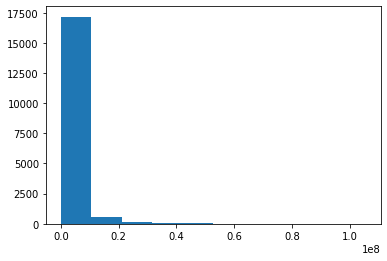

In [3]:
#histogramm: distribution of marketvalues
plt.hist(df.value_eur)

In [4]:
#number rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18028 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.4+ MB


In [5]:
#use only relevant columns
df = df[['sofifa_id','value_eur','age','height_cm','weight_kg','nationality','club','overall','potential','wage_eur','preferred_foot','international_reputation','weak_foot','skill_moves','work_rate','team_position','pace','shooting','passing','dribbling','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']]
df = df.dropna()
df = df[df.team_position != 'GK']
#tests were made with players only up to 15bn € market value
#modell needed less epochs, but loss went up 1%
#telling us that expensive player are rated more accurately
#df = df[df.value_eur < 15000000]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16032 entries, 0 to 18277
Data columns (total 51 columns):
sofifa_id                     16032 non-null int64
value_eur                     16032 non-null int64
age                           16032 non-null int64
height_cm                     16032 non-null int64
weight_kg                     16032 non-null int64
nationality                   16032 non-null object
club                          16032 non-null object
overall                       16032 non-null int64
potential                     16032 non-null int64
wage_eur                      16032 non-null int64
preferred_foot                16032 non-null object
international_reputation      16032 non-null int64
weak_foot                     16032 non-null int64
skill_moves                   16032 non-null int64
work_rate                     16032 non-null object
team_position                 16032 non-null object
pace                          16032 non-null float64
shooting         

In [7]:
#convert float values to int
df = df.fillna(0)
df.pace = df.pace.astype('int64')
df.shooting = df.shooting.astype('int64')
df.passing = df.passing.astype('int64')
df.dribbling = df.dribbling.astype('int64')
df.defending = df.defending.astype('int64')
df.physic = df.physic.astype('int64')

In [8]:
#reset index because rows and columns were removed from pandas dataframe
df = df.reset_index()
df.head()

,index,sofifa_id,value_eur,age,height_cm,weight_kg,nationality,club,overall,potential,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,0,158023,95500000,32,170,72,Argentina,FC Barcelona,94,94,...,94,48,40,94,94,75,96,33,37,26
1,1,20801,58500000,34,187,83,Portugal,Juventus,93,93,...,93,63,29,95,82,85,95,28,32,24
2,2,190871,105500000,27,175,68,Brazil,Paris Saint-Germain,92,92,...,84,51,36,87,90,90,94,27,26,29
3,4,183277,90000000,28,175,74,Belgium,Real Madrid,91,91,...,80,54,41,87,89,88,91,34,27,22
4,5,192985,90000000,28,181,70,Belgium,Manchester City,91,91,...,90,76,61,88,94,79,91,68,58,51


In [9]:
#get train and test set
df_train=df.sample(frac=0.8,random_state=200) #random state is a seed value
df_test=df.drop(df_train.index)


In [10]:
#split dataset into seperate datasets for categorical and numerical data 
df_nominal_train = df_train[['nationality','club','preferred_foot','work_rate','team_position']]
df_ordinal_train = df_train.drop(columns = ['nationality','club','preferred_foot','work_rate','team_position','sofifa_id','value_eur','index']) #zahlen mit rangordnung
df_solutions_train = df_train[['sofifa_id', 'value_eur']]

df_nominal_test = df_test[['nationality','club','preferred_foot','work_rate','team_position']]
df_ordinal_test = df_test.drop(columns = ['nationality','club','preferred_foot','work_rate','team_position','sofifa_id','value_eur','index']) #zahlen mit rangordnung
df_solutions_test = df_test[['sofifa_id', 'value_eur']]

In [11]:
#Map categorical values to ids 
nationalities = df.nationality.unique()
nationalities_dict = dict(zip(nationalities, range(len(nationalities))))
clubs = df.club.unique()
clubs_dict = dict(zip(clubs, range(len(clubs))))
preferred_foots = df.preferred_foot.unique()
preferred_foots_dict = dict(zip(preferred_foots, range(len(preferred_foots))))
work_rate = df.work_rate.unique()
work_rate_dict = dict(zip(work_rate, range(len(work_rate))))
team_positions = df.team_position.unique()
team_positions_dict = dict(zip(team_positions, range(len(team_positions))))

df_nominal_train = df_nominal_train.replace({'nationality': nationalities_dict})
df_nominal_train = df_nominal_train.replace({'club': clubs_dict})
df_nominal_train = df_nominal_train.replace({'preferred_foot': preferred_foots_dict})
df_nominal_train = df_nominal_train.replace({'work_rate': work_rate_dict})
df_nominal_train = df_nominal_train.replace({'team_position': team_positions_dict})

df_nominal_test = df_nominal_test.replace({'nationality': nationalities_dict})
df_nominal_test = df_nominal_test.replace({'club': clubs_dict})
df_nominal_test = df_nominal_test.replace({'preferred_foot': preferred_foots_dict})
df_nominal_test = df_nominal_test.replace({'work_rate': work_rate_dict})
df_nominal_test = df_nominal_test.replace({'team_position': team_positions_dict})

In [12]:
df_nominal_train.head()

,nationality,club,preferred_foot,work_rate,team_position
14383,62,90,1,2,18
13334,10,339,1,4,18
14944,34,157,1,4,18
15516,14,420,1,4,13
10006,4,471,0,4,13


In [13]:
#transform numerical values into the range 0 - 1
columns = df_ordinal_train.columns

scaler = MinMaxScaler()
df_ordinal_train = scaler.fit_transform(df_ordinal_train)
df_ordinal_test = scaler.transform(df_ordinal_test)

df_ordinal_train = pd.DataFrame(df_ordinal_train, columns=columns)
df_ordinal_test = pd.DataFrame(df_ordinal_test, columns=columns)

In [14]:
df_ordinal_train.head()

,age,height_cm,weight_kg,overall,potential,wage_eur,international_reputation,weak_foot,skill_moves,pace,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,0.217391,0.456522,0.352941,0.217391,0.326087,0.001773,0.0,0.50,0.0,0.647887,...,0.554217,0.517647,0.158537,0.559524,0.378049,0.567901,0.362319,0.297619,0.530864,0.5250
1,0.217391,0.804348,0.568627,0.260870,0.413043,0.000000,0.0,0.50,0.0,0.422535,...,0.060241,0.658824,0.646341,0.154762,0.195122,0.320988,0.188406,0.571429,0.654321,0.6500
2,0.130435,0.478261,0.313725,0.173913,0.369565,0.001773,0.0,0.50,0.0,0.169014,...,0.566265,0.258824,0.048780,0.535714,0.451220,0.728395,0.362319,0.130952,0.049383,0.1125
3,0.000000,0.782609,0.705882,0.108696,0.478261,0.000000,0.0,0.75,0.0,0.394366,...,0.144578,0.470588,0.487805,0.321429,0.207317,0.271605,0.188406,0.440476,0.530864,0.5125
4,0.130435,0.782609,0.607843,0.347826,0.565217,0.000000,0.0,0.50,0.0,0.577465,...,0.313253,0.717647,0.573171,0.202381,0.158537,0.320988,0.420290,0.595238,0.716049,0.6875


In [15]:
#convert categorical values to numpy array
np_nat_train = np.array(np_utils.to_categorical(df_nominal_train.nationality))
np_club_train = np.array(np_utils.to_categorical(df_nominal_train.club))
np_pref_train = np.array(np_utils.to_categorical(df_nominal_train.preferred_foot))
np_work_train = np.array(np_utils.to_categorical(df_nominal_train.work_rate))
np_team_train = np.array(np_utils.to_categorical(df_nominal_train.team_position))

np_nat_test = np.array(np_utils.to_categorical(df_nominal_test.nationality))
np_club_test = np.array(np_utils.to_categorical(df_nominal_test.club))
np_pref_test = np.array(np_utils.to_categorical(df_nominal_test.preferred_foot))
np_work_test = np.array(np_utils.to_categorical(df_nominal_test.work_rate))
np_team_test = np.array(np_utils.to_categorical(df_nominal_test.team_position))

In [16]:
print(np_nat_train[500])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
#merge all data into one big vector (for model performance only numerical values were used,
#if categorical and numerical columns were used along, the loss would be around 17% )
#np_nat_train, np_club_train, np_pref_train, np_work_train, np_team_train
train = np.hstack([df_ordinal_train])
test = np.hstack([df_ordinal_test])
sol_train = np.array(df_solutions_train.value_eur)
sol_test = np.array(df_solutions_test.value_eur)

In [18]:
test.shape


(3206, 44)

In [19]:
train.shape

(12826, 44)

In [20]:
print(train[0])

[0.2173913  0.45652174 0.35294118 0.2173913  0.32608696 0.00177305
 0.         0.5        0.         0.64788732 0.52564103 0.38235294
 0.45714286 0.36       0.57142857 0.46341463 0.54117647 0.51851852
 0.49275362 0.56962025 0.51851852 0.25301205 0.38095238 0.45205479
 0.41666667 0.65277778 0.64788732 0.5942029  0.30769231 0.6056338
 0.5125     0.52857143 0.67647059 0.54666667 0.55421687 0.51764706
 0.15853659 0.55952381 0.37804878 0.56790123 0.36231884 0.29761905
 0.5308642  0.525     ]


In [21]:
#format of the solution dataset 
df_solutions_train.head()

,sofifa_id,value_eur
14383,233948,180000
13334,232272,280000
14944,240105,140000
15516,248187,110000
10006,251809,700000


In [22]:
#create the deep learning model
from keras import optimizers

model = Sequential()
model.add(Dense(256, activation="relu",input_dim=train.shape[1]))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))
model.compile(loss='mean_absolute_percentage_error',optimizer='adam')

#train the model
model.fit(train, sol_train, epochs=250, batch_size = 8 )

Epoch 1/250
12826/12826 [==============================] - 2s 122us/step - loss: 72.6323
Epoch 2/250
12826/12826 [==============================] - 1s 103us/step - loss: 66.5378
Epoch 3/250
12826/12826 [==============================] - 1s 104us/step - loss: 64.1988
Epoch 4/250
12826/12826 [==============================] - 1s 105us/step - loss: 59.4941
Epoch 5/250
12826/12826 [==============================] - 1s 102us/step - loss: 53.2732
Epoch 6/250
12826/12826 [==============================] - 1s 101us/step - loss: 48.6235
Epoch 7/250
12826/12826 [==============================] - 1s 102us/step - loss: 44.4044
Epoch 8/250
12826/12826 [==============================] - 1s 105us/step - loss: 40.6815
Epoch 9/250
12826/12826 [==============================] - 1s 105us/step - loss: 37.5720
Epoch 10/250
12826/12826 [==============================] - 2s 146us/step - loss: 33.7721
Epoch 11/250
12826/12826 [==============================] - 1s 107us/step - loss: 30.0904
Epoch 12/250
12826/

12826/12826 [==============================] - 1s 91us/step - loss: 10.1448
Epoch 93/250
12826/12826 [==============================] - 1s 92us/step - loss: 10.1082
Epoch 94/250
12826/12826 [==============================] - 1s 101us/step - loss: 10.0702
Epoch 95/250
12826/12826 [==============================] - 1s 93us/step - loss: 10.0844
Epoch 96/250
12826/12826 [==============================] - 1s 92us/step - loss: 10.1135
Epoch 97/250
12826/12826 [==============================] - 1s 92us/step - loss: 10.0709
Epoch 98/250
12826/12826 [==============================] - 1s 93us/step - loss: 10.0818
Epoch 99/250
12826/12826 [==============================] - 1s 92us/step - loss: 10.0397
Epoch 100/250
12826/12826 [==============================] - 1s 95us/step - loss: 10.0556
Epoch 101/250
12826/12826 [==============================] - 1s 92us/step - loss: 10.0690
Epoch 102/250
12826/12826 [==============================] - 1s 94us/step - loss: 10.0539
Epoch 103/250
12826/12826 [===

12826/12826 [==============================] - 1s 98us/step - loss: 9.5985
Epoch 184/250
12826/12826 [==============================] - 1s 97us/step - loss: 9.6242
Epoch 185/250
12826/12826 [==============================] - 1s 96us/step - loss: 9.5940
Epoch 186/250
12826/12826 [==============================] - 1s 100us/step - loss: 9.5785
Epoch 187/250
12826/12826 [==============================] - 1s 97us/step - loss: 9.5455
Epoch 188/250
12826/12826 [==============================] - 1s 98us/step - loss: 9.5778
Epoch 189/250
12826/12826 [==============================] - 1s 97us/step - loss: 9.5477
Epoch 190/250
12826/12826 [==============================] - 1s 98us/step - loss: 9.5333
Epoch 191/250
12826/12826 [==============================] - 1s 97us/step - loss: 9.5501
Epoch 192/250
12826/12826 [==============================] - 1s 114us/step - loss: 9.5489
Epoch 193/250
12826/12826 [==============================] - 1s 108us/step - loss: 9.5796
Epoch 194/250
12826/12826 [=====

In [23]:
#let the model predict the test values
preds = model.predict(test)  

In [24]:
#calculate the loss of the test set with the solution set
abw = []
for i in range(len(preds)):
    abw.append(((sol_test[i] - int(preds[i])) / sol_test[i] * 100 )) 

summ = 0
for line in abw:
    if line < 0:
        line = line * -1
    summ = summ + line

print(summ / len(abw))

print(max(abw))
print(min(abw))
    

10.059027271042448
38.767589743589745
-173.20374999999999


(array([3.000e+00, 2.000e+00, 4.000e+00, 1.000e+01, 1.600e+01, 4.300e+01,
        9.800e+01, 8.340e+02, 2.019e+03, 1.770e+02]),
 array([-173.20375   , -152.00661603, -130.80948205, -109.61234808,
         -88.4152141 ,  -67.21808013,  -46.02094615,  -24.82381218,
          -3.62667821,   17.57045577,   38.76758974]),
 <a list of 10 Patch objects>)

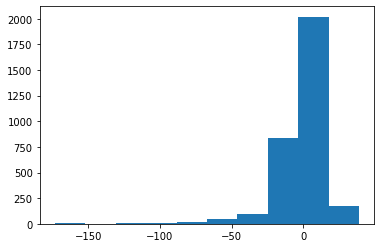

In [25]:
#plot error distribution of the predictions
plt.hist(abw)